# Assignment 2.1 - Clustering

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[Jane and John Doe]

In [1]:
# Daniel Thompson and Paola Gega

## Grading Info/Details - Assignment 2.1:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

## Task 2.1.1 - kMeans

kMeans is an unsupervised learning algorithm that partitions n observations into k clusters. Each observation belongs to the cluster with the nearest mean (cluster center or centroid).


### 1. kMeans Implementation
* Implement the kMeans clustering algorithm using `numpy` only. Use the `KMeans` class structure below. **(RESULT)**
* Test the convergence of your implementation by creating a 2D synthetic dataset yourself. Report on the convergence. **(RESULT)**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class KMeans:
    def __init__(self, k=3, max_iters=100, tol=1e-4, random_state=None, silent=False):
        """
        Initialize KMeans clusterer.
        
        Parameters:
        -----------
        k : int
            Number of clusters
        max_iters : int
            Maximum number of iterations
        tol : float
            Tolerance for convergence (change in centroids)
        random_state : int or None
            Random seed for reproducibility
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.labels_ = None
        self.silent = silent

    def euclidean_distance_vectorized(self, X_1, X_2):
            """
            Vectorized computation of Euclidean distances.
            More efficient for multiple test samples.

            Parameters:
            X_1 (ndarray): Test samples of shape (n_1, m)
            X_2 (ndarray): Test samples of shape (n_2, m)

            Returns:
            ndarray: Distance matrix of shape (n_1, n_2)
            """
            # Using broadcasting for efficient computation
            # ||X_1 - X_2||^2 = ||X_1||^2 + ||X_2||^2 - 2*X_1·X_2

            # X_1 - SHAPE (n_1, m)
            # X_2 - SHAPE (n_2, m)
            X_1_sqnorms = np.sum(X_1**2, axis=1, keepdims=True)  # (n_1, 1)
            X_2_sqnorms = np.sum(X_2**2, axis=1)  # (n_2, 1)
            dots = np.dot(X_1, X_2.T)  # (n_1, n_2)

            # quick and dirty way to deal with trying to square root a negative
            temp = X_1_sqnorms + X_2_sqnorms - 2 * dots
            temp[temp<0] = 0

            distances = np.sqrt(temp)  # X_1_sqnorms + X_2_sqnorms - broadcasted addition (n_1, n_2)
            # distances[np.isnan(distances)] = 0
            return distances  # SHAPE (n_1, n_2)

    
    def initialize_centroids(self, X):
        """
        Initialize cluster centers using random selection from data points.
        """
        n = len(X)
        self.labels_ = np.empty(n, dtype=int)
        # Choose k distinct random points from the data to use for the first step of the algorithm
        rng = np.random.default_rng(seed=self.random_state)
        inds = rng.choice(n, self.k, replace=False)
        self.centroids = np.empty((self.k, len(X[0])), dtype=float)
        self.centroids = X[inds]
    
    def initialize_centroids_plusplus(self, X): # for the following Subtask
        n = len(X)
        self.labels_ = np.empty(n, dtype=int)
        rng = np.random.default_rng(seed=self.random_state)
        # Initialize first centroid
        self.centroids = X[rng.choice(n, 1)]
        count = 1
        # Draw subsequent centroid points according to knn++ algorithm
        while count < self.k:
            distances = self.euclidean_distance_vectorized(X, self.centroids)
            # Construct a vector of probability for drafting the next point
            squared_dist = np.min(distances, axis=1)**2
            tot = np.sum(squared_dist)
            prob = squared_dist / tot
            self.centroids = np.vstack([self.centroids, X[rng.choice(n,1,p=prob)]])
            count += 1        
    
    def fit(self, X):
        """
        Fit the KMeans model to data X.
        """
        # Nothing to be done here that isn't accounted for by other methods.
        pass
    
    def predict(self, X):
        """
        Predict cluster labels for new data.
        """
        distances = self.euclidean_distance_vectorized(X, self.centroids)
        # Assign each data point to the cluster corresponding to its closest centroid
        labels = np.argmin(distances, axis=1)
        return labels
    
    def fit_predict(self, X):
        """
        Perform KMeans clustering and return cluster labels.
        """
        self.fit(X)
        iter = 0
        while (iter < self.max_iters):
            iter += 1
            self.labels_ = self.predict(X)
            # Calculate the new centroid of the each class
            new_centroids = np.empty((self.k, len(X[0])), dtype=float)
            deltas = np.empty(self.k, dtype=float)
            for i in range(self.k):
                new_centroids[i] = np.mean(X[self.labels_ == i], axis = 0)
                deltas[i] = np.sqrt(np.sum((self.centroids[i] - new_centroids[i])**2))
            # Algorithm terminates if convergence condition is met
            self.centroids = new_centroids
            if np.max(deltas[i])<self.tol:
                self.labels_ = self.predict(X)
                break
        if iter == self.max_iters and (not self.silent):
            print("Did not converge within", self.max_iters, "iterations!")
        elif not self.silent:
            print("Converged after", iter, "iterations!")
        # Calculate average within-cluster variance
        distances = self.euclidean_distance_vectorized(X, self.centroids)
        # Calculate the silhouettes
        # This code could definitely be optimized!
        n = len(X)
        a = np.zeros(n, dtype=float)
        b = np.zeros(n, dtype=float)
        for i in range(n):
            mask = np.ones(n,dtype=bool)
            mask[i] = 0
            lab = self.labels_[i]
            a[i] = np.mean(self.euclidean_distance_vectorized(X[i][np.newaxis,:],X[(self.labels_==lab) & mask]))
            other_labels = np.unique(self.labels_[self.labels_ != lab])
            num_other_clusters = len(other_labels)
            # mean distance of X[i] to all points of another cluster
            mean_dist_to_others = np.empty(num_other_clusters, dtype=float)
            for l in range(num_other_clusters):
                mean_dist_to_others[l] = np.mean(self.euclidean_distance_vectorized(X[i][np.newaxis,:],X[self.labels_==other_labels[l]]))
            b[i] = np.min(mean_dist_to_others)
        sil = np.zeros(n, dtype=float)
        sil[a<b] = (1 - (a/b))[a<b]
        sil[b<a] = ((b/a) - 1)[b<a]
        # Return the average silhouette, loss, and predicted labels
        return np.mean(sil), np.sum(np.min(distances, axis=1)**2)/len(X), self.labels_

In [4]:
# Generate some synthetic 2-dimensional data
X = np.vstack((np.random.multivariate_normal((1,0), [[1, 0], [0, 4]], 1000),np.random.multivariate_normal((0,1), [[4, 0], [0, 1]], 1000),np.random.multivariate_normal((0,0), [[3, 1], [1, 3]], 1000)))
true_labels = np.zeros(3000, dtype=int)
true_labels[1000:2000] = 1
true_labels[2000:3000] = 2

# Run kMeans on the data
KM = KMeans(k=3)
KM.initialize_centroids(X)
sil, var, lab = KM.fit_predict(X)
print("Average within-cluster variance:", var)
# Let's see how many points were grouped into each cluster.
# for i in range(3):
#     print(np.sum(predicted_labels == i))

Converged after 19 iterations!
Average within-cluster variance: 2.4980378793172253


**Remark:** We are sometimes getting a message that we are taking the square root of a negative number.  This part of the code was taken directly from Manuel's sample code.  We are assuming that it is just due to a rounding error, and it does not seem to prevent the algorithm from working correctly.

### 2. kMeans++ initialization

* Implement the kMeans++ initialization method in the KMeans class. **(RESULT)**
* Compare the convergence speed of kMeans with random initialization and kMeans++ initialization on your synthetic dataset from Part 1. **(RESULT)**

In [5]:
# Run kMeans on the data after using the kMeans++ initialization function
KM = KMeans(k=3)
KM.initialize_centroids_plusplus(X)
sil, var, lab = KM.fit_predict(X)
print("Average within-cluster variance:", var)

Converged after 8 iterations!
Average within-cluster variance: 2.4980571190249368


**Report:** kMeans++ converged in less than half as many steps in this case!  Usually it appears to be a much smaller fraction, and in some cases, it is slower--probably due to the random selection.

### 3. Visualization of Cluster Quality


* Visualize the clustering results of your kMeans implementation on a synthetic 2D dataset with at least 4 clusters using matplotlib. **(RESULT)**
* Determine the optimal number of clusters using the elbow method. Report on your findings using a simple plot. **(RESULT)**
* Report on the silhouette score of your clustering results for the optimal k and k-1. **(RESULT)**

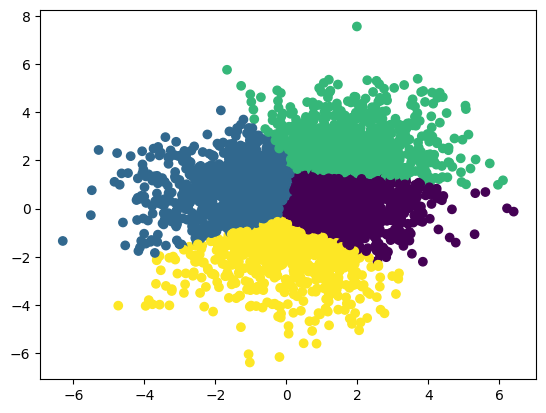

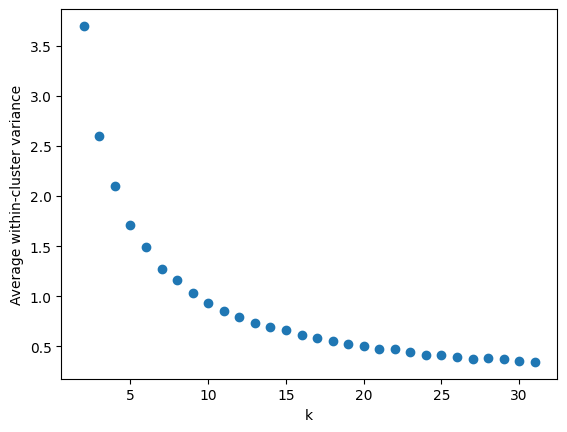

In [6]:
# Generate a synthetic 2-dimensional data set with 4 clusters
X = np.vstack((np.random.multivariate_normal((1,0), [[1, 0], [0, 4]], 1000),np.random.multivariate_normal((0,1), [[4, 0], [0, 1]], 1000),np.random.multivariate_normal((0,0), [[3, 1], [1, 3]], 1000),np.random.multivariate_normal((1,1), [[3, 1], [1, 3]], 1000)))

KM = KMeans(k=4, silent=True)
KM.initialize_centroids_plusplus(X)
lab = KM.fit_predict(X)[2]

plt.scatter(X[:, 0], X[:, 1], c=lab)
plt.show()

l = []
for k in range(30):
    KM = KMeans(k+2, silent=True)
    KM.initialize_centroids_plusplus(X)
    sil, var, lab = KM.fit_predict(X)
    l.append(var)

plt.scatter(range(2,32), l)
plt.xlabel('k')
plt.ylabel('Average within-cluster variance')
plt.show()

**Report:** Our model quality appears to keep increasing rapidly until, let us say, k=10.

In [7]:
# Now let's check the silhouette score

for k in [3,4,9,10]:
    KM = KMeans(k, silent=True)
    KM.initialize_centroids_plusplus(X)
    sil, var, lab = KM.fit_predict(X)
    print("Average silhouette for k={}:".format(k), sil)

Average silhouette for k=3: 0.3463438339998515
Average silhouette for k=4: 0.3235819052219882
Average silhouette for k=9: 0.30966737755626716
Average silhouette for k=10: 0.3159439105722904


## Task 2.1.2 - DBSCAN (BONUS)

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together, marking outliers points that lie alone in low-density regions.

* Implement the DBSCAN algorithm using `numpy` only. Use the `DBSCAN` class structure below. **(RESULT)**
* Test your DBSCAN implementation on a synthetic 2D dataset with noise. Visualize the clustering results using matplotlib. **(RESULT)**
* Compare the performance of your DBSCAN implementation with your kMeans implementation on the same synthetic 2D dataset using silhouette score as a metric. Please use the same random seed to make it comparable. **(RESULT)**


In [8]:
from collections import deque   # Useful for efficient BFS implementation (FIFO) for iterating through neighboring points

class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5, metric='euclidean'):
        """
        Parameters:
        -----------
        eps : float
            Maximum distance between two samples for them to be considered neighbors
        min_samples : int
            Number of samples in a neighborhood for a point to be considered a core point
            (including the point itself)
        metric : str
            Distance metric to use ('euclidean' or 'manhattan')
        """
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.labels_ = None
        self.core_sample_indices_ = None
        self.components_ = None
        self.n_clusters_ = None
        self.n_noise_ = None
    
    def fit(self, X):
        """
        Perform DBSCAN clustering.
        """
        # TODO: Implement this function
        pass
    
    def predict(self, X_new):
        """
        Predict the closest cluster for new points.
        Note: New points can only be assigned to existing clusters or marked as noise.
        """
        # TODO: Implement this function
        pass
    
    def fit_predict(self, X):
        """
        Perform DBSCAN clustering and return cluster labels.
        
        """
        self.fit(X)
        return self.labels_

## Congratz, you made it! :)